In [1]:
import pandas as pd
#import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

df = pd.read_csv('churn_data.csv')

In [2]:
df

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


# Data Processing

In [3]:
# Converts total charges from string to float
df['Total Charges'] = df['Total Charges'].replace(r'^\s*$', np.nan, regex=True)
df['Total Charges'] = df['Total Charges'].astype(float)
# Choosing variables apart from Churn Label, Churn reason (not applicable for modelling)
df1 = df[['Country', 'State', 'City','Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method','Monthly Charges', 'Total Charges','Churn Value']]

In [4]:
# One hot encodeing all variables
df_encoded = pd.get_dummies(df1, columns=['Gender', 'Senior Citizen', 'Partner', 'Dependents','Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'])

In [5]:
df_encoded

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,United States,California,Los Angeles,90003,33.964131,-118.272783,2,53.85,108.15,1,...,0,1,0,0,0,1,0,0,0,1
1,United States,California,Los Angeles,90005,34.059281,-118.307420,2,70.70,151.65,1,...,0,1,0,0,0,1,0,0,1,0
2,United States,California,Los Angeles,90006,34.048013,-118.293953,8,99.65,820.50,1,...,1,1,0,0,0,1,0,0,1,0
3,United States,California,Los Angeles,90010,34.062125,-118.315709,28,104.80,3046.05,1,...,1,1,0,0,0,1,0,0,1,0
4,United States,California,Los Angeles,90015,34.039224,-118.266293,49,103.70,5036.30,1,...,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,United States,California,Landers,92285,34.341737,-116.539416,72,21.15,1419.40,0,...,0,0,0,1,0,1,1,0,0,0
7039,United States,California,Adelanto,92301,34.667815,-117.536183,24,84.80,1990.50,0,...,1,0,1,0,0,1,0,0,0,1
7040,United States,California,Amboy,92304,34.559882,-115.637164,72,103.20,7362.90,0,...,1,0,1,0,0,1,0,1,0,0
7041,United States,California,Angelus Oaks,92305,34.167800,-116.864330,11,29.60,346.45,0,...,0,1,0,0,0,1,0,0,1,0


In [6]:
# Dropping dummy variables
df_encoded = df_encoded.drop(['Multiple Lines_No phone service', 'Online Security_No internet service', 'Online Backup_No internet service','Device Protection_No internet service', 'Tech Support_No internet service', 'Streaming TV_No internet service', 'Streaming Movies_No internet service', 'Gender_Female', 'Senior Citizen_No', 'Partner_No', 'Paperless Billing_No', 'Dependents_No', 'Phone Service_No', 'Multiple Lines_No', 'Internet Service_No', 'Online Security_No', 'Online Backup_No', 'Device Protection_No', 'Tech Support_No', 'Streaming TV_No', 'Streaming Movies_No', 'Contract_One year', 'Payment Method_Mailed check'], axis = 1)
# Scaling continuous variable
scaler = StandardScaler()
df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaler.fit_transform(df_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']])
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,0,1,0,1,0,0,0
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,0,1,0,1,0,0,1
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,1,0,1,1,1,0,1,0,0,1
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,1,0,1,0,0,1
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,1,0,1,1,1,0,1,1,0,0


In [7]:
df_la = df_encoded[df_encoded['Zip Code'] == 90012]
df_la.columns

Index(['Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude',
       'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Gender_Male', 'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Phone Service_Yes', 'Multiple Lines_Yes', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Online Security_Yes',
       'Online Backup_Yes', 'Device Protection_Yes', 'Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Contract_Month-to-month',
       'Contract_Two year', 'Paperless Billing_Yes',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check'],
      dtype='object')

In [8]:
# Dealing with Latitude and Longitude variables by finding manhatten distance
from math import radians
import math

# Define the central location
central_lat = radians(34.065875)
central_lon = radians(-118.238728)

# Define a function to calculate the Manhattan distance
def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calculate the Manhattan distance between two points."""
    dx = abs(lon2 - lon1) * 6371 * math.cos((lat1 + lat2) / 2)
    dy = abs(lat2 - lat1) * 6371
    return dx + dy

# Apply the function to each row in the DataFrame
df_encoded['manhattan_distance'] = df_encoded.apply(lambda x: manhattan_distance(radians(x['Latitude']), radians(x['Longitude']), central_lat, central_lon), axis=1)

# View the updated DataFrame
df_encoded.head()

,Country,State,City,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,...,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_Month-to-month,Contract_Two year,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,manhattan_distance
0,United States,California,Los Angeles,90003,33.964131,-118.272783,-1.236724,-0.362660,-0.959649,1,...,0,0,0,1,0,1,0,0,0,14.452214
1,United States,California,Los Angeles,90005,34.059281,-118.307420,-1.236724,0.197365,-0.940457,1,...,0,0,0,1,0,1,0,0,1,7.060907
2,United States,California,Los Angeles,90006,34.048013,-118.293953,-0.992402,1.159546,-0.645369,1,...,0,1,1,1,0,1,0,0,1,7.073653
3,United States,California,Los Angeles,90010,34.062125,-118.315709,-0.177995,1.330711,0.336516,1,...,1,1,1,1,0,1,0,0,1,7.508106
4,United States,California,Los Angeles,90015,34.039224,-118.266293,0.677133,1.294151,1.214589,1,...,0,1,1,1,0,1,1,0,0,5.502956


In [9]:
df_encoded[['manhattan_distance']] = scaler.fit_transform(df_encoded[['manhattan_distance']])
df_features = df_encoded.drop(['Latitude', 'Longitude', 'Zip Code', 'Country', 'State', 'City'], axis=1)
df_features = df_features.dropna()

### We now run LightGBM on our dataset with features from our RFECV Decision Tree Estimator 

In [10]:
data = df_features

X = data.drop(['Churn Value'], axis=1)
y = data['Churn Value']

In [11]:
X.columns

# Select features from RFECV - Decision Tree Estimator
X = X[['Tenure Months', 'Monthly Charges', 'Total Charges',
       'Gender_Male', 'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Internet Service_Fiber optic', 'Online Security_Yes',
       'Contract_Month-to-month','Contract_Two year', 'Paperless Billing_Yes', 'manhattan_distance']]

# remove special character
X.columns = X.columns.str.replace(' ', '_')
X

,Tenure_Months,Monthly_Charges,Total_Charges,Gender_Male,Senior_Citizen_Yes,Partner_Yes,Dependents_Yes,Internet_Service_Fiber_optic,Online_Security_Yes,Contract_Month-to-month,Contract_Two_year,Paperless_Billing_Yes,manhattan_distance
0,-1.236724,-0.362660,-0.959649,1,0,0,0,0,1,1,0,1,-1.210940
1,-1.236724,0.197365,-0.940457,0,0,0,1,1,0,1,0,1,-1.230802
2,-0.992402,1.159546,-0.645369,0,0,0,1,1,0,1,0,1,-1.230767
3,-0.177995,1.330711,0.336516,0,0,1,1,1,0,1,0,1,-1.229600
4,0.677133,1.294151,1.214589,1,0,0,1,1,0,1,0,1,-1.234988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.613701,-1.449476,-0.381142,0,0,0,0,0,0,0,1,1,-0.747410
7039,-0.340876,0.665992,-0.129180,1,0,1,1,0,1,0,0,1,-0.896637
7040,1.613701,1.277533,2.241056,0,0,1,1,1,0,0,0,1,-0.460094
7041,-0.870241,-1.168632,-0.854514,0,0,1,1,0,1,1,0,1,-0.879326


## LIGHT GBM

In [12]:
#These are the columns we will use
X.columns

Index(['Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'Gender_Male',
       'Senior_Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Internet_Service_Fiber_optic', 'Online_Security_Yes',
       'Contract_Month-to-month', 'Contract_Two_year', 'Paperless_Billing_Yes',
       'manhattan_distance'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
import lightgbm
from lightgbm import LGBMRegressor, LGBMClassifier

#Create training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,train_size = 0.80)

## Creating our model and evaluating performance

In [14]:
base_mod = LGBMClassifier()
#Parameters of our Classifier
base_mod.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [15]:
#Fitting model with our training data. This is done without parameter tuning
base_mod.fit(X_train,Y_train)

LGBMClassifier()

### We now create a function to summarise our models and evaluative criteria

In [16]:
#Function to summaries effectiveness of different models
def evaluate_model(name, train_preds, test_preds):
    print(f"Evaluation of {name} model:")
    print("Training set:")
    print("F1 Score (Per Class):", f1_score(Y_train, np.round(train_preds), average=None))
    print("AUC Score:", roc_auc_score(Y_train, train_preds))
    
    cm_train = confusion_matrix(Y_train, np.round(train_preds))
    cm_train_percent = cm_train / cm_train.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_train_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Training set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Test set:")
    print("F1 Score (Per Class):", f1_score(Y_test, np.round(test_preds), average=None))
    print("AUC Score:", roc_auc_score(Y_test, test_preds))
    
    cm_test = confusion_matrix(Y_test, np.round(test_preds))
    cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Test set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Evaluation of Base LightGBM model:
Training set:
F1 Score (Per Class): [0.93067177 0.79889043]
AUC Score: 0.9609840963087845


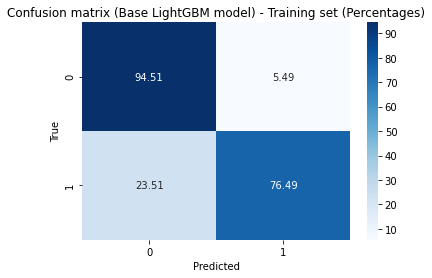

Test set:
F1 Score (Per Class): [0.85174693 0.54885057]
AUC Score: 0.6950777366137868


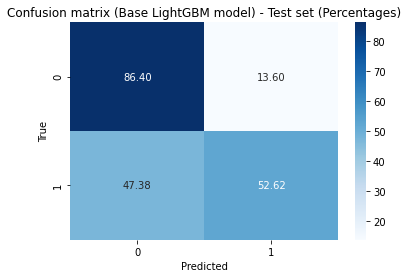

In [17]:
#Evaluating our base LightGBM model without parameter tuning
evaluate_model("Base LightGBM", base_mod.predict_proba(X_train)[:,1], base_mod.predict(X_test))

#### This performs ok. Can we use parameter tuning to make it better?

In [18]:
#Specifying our parameters
parameters = {
    'learning_rate' : [0.01, 0.1, 0.5],
    'num_leaves' : np.arange(10,81,5),
    #Number of trees that will be in of our model
    'n_estimators' : [50, 100,150,200]
}

#Performing Grid Search
tuned_mod = LGBMClassifier()

search = GridSearchCV(tuned_mod, parameters, cv = 5, scoring = 'roc_auc',verbose = 2)
 
search.fit(X_train, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] learning_rate=0.01, n_estimators=50, num_leaves=10 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=10, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=10 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=10, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=10 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=10, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=10 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=10, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=10 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=10, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=15 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=15, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=15 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=15, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=15 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=15, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=15 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=15, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=15 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=15, total=   0.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=20 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=20, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=20 ..............

[CV]  learning_rate=0.01, n_estimators=50, num_leaves=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=70 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=70 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=75 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=75, total=   0.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=75 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=75, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=75 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=75, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=75 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=75, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=75 ..............

[CV] learning_rate=0.01, n_estimators=100, num_leaves=55 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=55, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=55 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=55, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=55 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=55, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=55 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=55, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=55 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=55, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=60 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=60, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100, num_leaves=60 .............
[CV]  learning_rate=0.01, n_estimators=100, num_leaves=60, total=

[CV] learning_rate=0.01, n_estimators=150, num_leaves=35 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=35, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=35 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=35, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=40 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=40, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=40 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=40, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=40 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=40, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=40 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=40, total=   0.2s
[CV] learning_rate=0.01, n_estimators=150, num_leaves=40 .............
[CV]  learning_rate=0.01, n_estimators=150, num_leaves=40, total=

[CV] learning_rate=0.01, n_estimators=200, num_leaves=20 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=20, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=20 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=20, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=20 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=20, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=20 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=20, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=25 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=25, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=25 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=25, total=   0.2s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=25 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=25, total=

[CV]  learning_rate=0.01, n_estimators=200, num_leaves=75, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=75 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=75, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=80, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=80, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=80, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=80, total=   0.5s
[CV] learning_rate=0.01, n_estimators=200, num_leaves=80 .............
[CV]  learning_rate=0.01, n_estimators=200, num_leaves=80, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=10 ........

[CV] learning_rate=0.1, n_estimators=50, num_leaves=60 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=60, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=60 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=60, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=60 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=60, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=60 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=60, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=65 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=65, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=65 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=65, total=   0.1s
[CV] learning_rate=0.1, n_estimators=50, num_leaves=65 ...............
[CV]  learning_rate=0.1, n_estimators=50, num_leaves=65, total=   0.1s
[CV] l

[CV] learning_rate=0.1, n_estimators=100, num_leaves=40 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=40, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=45 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=45, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=45 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=45, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=45 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=45, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=45 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=45, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=45 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=45, total=   0.1s
[CV] learning_rate=0.1, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=100, num_leaves=50, total=   0.2s

[CV]  learning_rate=0.1, n_estimators=150, num_leaves=25, total=   0.1s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=25 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=25, total=   0.1s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=25 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=25, total=   0.2s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=30 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=30, total=   0.2s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=30 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=30, total=   0.2s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=30 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=30, total=   0.2s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=30 ..............
[CV]  learning_rate=0.1, n_estimators=150, num_leaves=30, total=   0.2s
[CV] learning_rate=0.1, n_estimators=150, num_leaves=30 ..............

[CV]  learning_rate=0.1, n_estimators=200, num_leaves=10, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=10, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=10, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=10, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=15 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=15, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=15 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=15, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=15 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=15, total=   0.1s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=15 ..............

[CV]  learning_rate=0.1, n_estimators=200, num_leaves=65, total=   0.5s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=70 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=70, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=70 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=70, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=70 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=70, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=70 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=70, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=70 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=70, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=75 ..............
[CV]  learning_rate=0.1, n_estimators=200, num_leaves=75, total=   0.4s
[CV] learning_rate=0.1, n_estimators=200, num_leaves=75 ..............

[CV] learning_rate=0.5, n_estimators=50, num_leaves=50 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=50, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=55 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=55, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=55 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=55, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=55 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=55, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=55 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=55, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=55 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=55, total=   0.1s
[CV] learning_rate=0.5, n_estimators=50, num_leaves=60 ...............
[CV]  learning_rate=0.5, n_estimators=50, num_leaves=60, total=   0.1s
[CV] l

[CV]  learning_rate=0.5, n_estimators=100, num_leaves=35, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=35 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=35, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=35 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=35, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=40 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=40, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=40 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=40, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=40 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=40, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=40 ..............
[CV]  learning_rate=0.5, n_estimators=100, num_leaves=40, total=   0.1s
[CV] learning_rate=0.5, n_estimators=100, num_leaves=40 ..............

[CV]  learning_rate=0.5, n_estimators=150, num_leaves=20, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=20 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=20, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=20 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=20, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=20 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=20, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=25 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=25, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=25 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=25, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=25 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=25, total=   0.1s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=25 ..............

[CV]  learning_rate=0.5, n_estimators=150, num_leaves=75, total=   0.4s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=80 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=80, total=   0.5s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=80 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=80, total=   0.4s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=80 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=80, total=   0.4s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=80 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=80, total=   0.3s
[CV] learning_rate=0.5, n_estimators=150, num_leaves=80 ..............
[CV]  learning_rate=0.5, n_estimators=150, num_leaves=80, total=   0.3s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=10, total=   0.1s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=10 ..............

[CV]  learning_rate=0.5, n_estimators=200, num_leaves=60, total=   0.5s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=60 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=60, total=   0.4s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=60 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=60, total=   0.4s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=65 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=65, total=   0.5s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=65 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=65, total=   0.4s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=65 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=65, total=   0.4s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=65 ..............
[CV]  learning_rate=0.5, n_estimators=200, num_leaves=65, total=   0.5s
[CV] learning_rate=0.5, n_estimators=200, num_leaves=65 ..............

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])},
             scoring='roc_auc', verbose=2)

In [19]:
#Get the best parameter values after tuning
print(search.best_params_)
print("\n")
#We now fit a new model with these best parameters according to GridSearch
tuned_mod = LGBMClassifier(learning_rate = 0.1, n_estimators = 50, num_leaves = 10)

tuned_mod.fit(X_train, Y_train)

{'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 10}




LGBMClassifier(n_estimators=50, num_leaves=10)

Evaluation of Tuned LightGBM model:
Training set:
F1 Score (Per Class): [0.8838312  0.65174129]
AUC Score: 0.8861312861365093


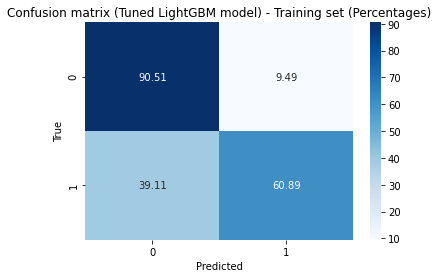

Test set:
F1 Score (Per Class): [0.86022514 0.56304985]
AUC Score: 0.7036390551280833


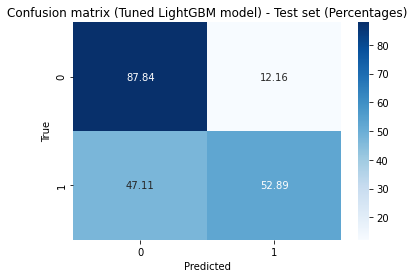

In [20]:
#Evaluate tuned LightGBM Model
evaluate_model("Tuned LightGBM", tuned_mod.predict_proba(X_train)[:,1], tuned_mod.predict(X_test))

From the above data, we see that our model performs particularly slightly better after hyperparameter tuning. We also see that classification for class 1 is nowhere near as good as classification for class 0. How can we fix this?

In [21]:
#We see that there are much more instances of class 0 than there are for class 1.
#How can we balance the data to account for this?
Y_test.value_counts()

0    1044
1     363
Name: Churn Value, dtype: int64

#### We use imblearn to generate new samples in our minority class via oversampling. Oversampling does this by picking samples at random with replacement until both classes are balanced.

In [22]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(X_train,Y_train)
print(y_ros.value_counts())


#Create training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(x_ros,y_ros,train_size = 0.80)

0    4119
1    4119
Name: Churn Value, dtype: int64


In [23]:
#We now fit a new model with these best parameters according to GridSearch
best_mod = LGBMClassifier(learning_rate = 0.1, n_estimators = 50, num_leaves = 10)

best_mod.fit(X_train, Y_train)

LGBMClassifier(n_estimators=50, num_leaves=10)

Evaluation of Final LightGBM model:
Training set:
F1 Score (Per Class): [0.79647133 0.81088993]
AUC Score: 0.8040392702893563


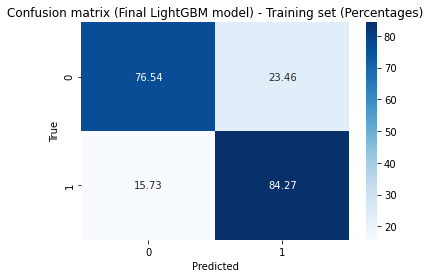

Test set:
F1 Score (Per Class): [0.7862069  0.79952969]
AUC Score: 0.7928450226244343


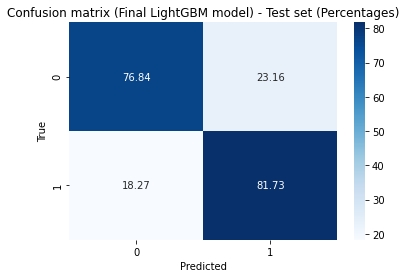

In [24]:
#Evaluate Light GBM Model after oversampling from class 1
evaluate_model("Final LightGBM", best_mod.predict(X_train), best_mod.predict(X_test))

We see that this model performs overall better in terms of classification, especially for class of 1. However class predictions of 0 are not as good.

# Model Explanation

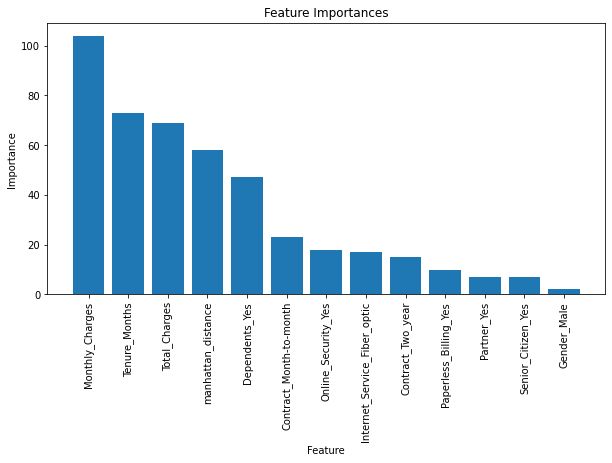

In [31]:
# Get the feature importances with the corresponding feature names
feature_importances = best_mod.feature_importances_
feature_names = X_train.columns.tolist()

# Sort the features by importance in descending order
sorted_idx = feature_importances.argsort()[::-1]
feature_importances_sorted = feature_importances[sorted_idx]
feature_names_sorted = [feature_names[i] for i in sorted_idx]

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.bar(feature_names_sorted, feature_importances_sorted)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [26]:
# Generate SHAP values
explainer = shap.Explainer(best_mod, X_train)
shap_values = explainer(X_train)

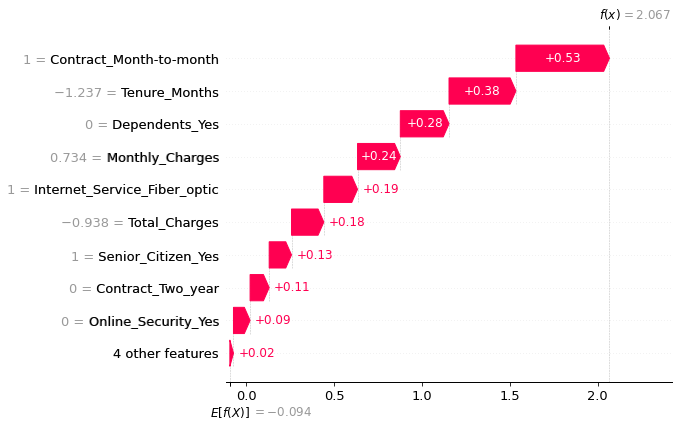

In [27]:
# Plot SHAP values for a single instance

# Following describes someone who is predicted to churn and the features contributing to how the model predicted this. 
shap.plots.waterfall(shap_values[1])

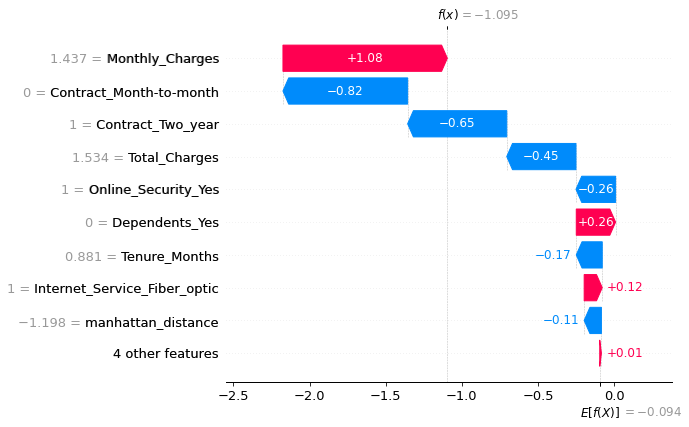

In [28]:
# Following describes someone who didn't churn and some factors of the model that predicted this.
shap.plots.waterfall(shap_values[3])

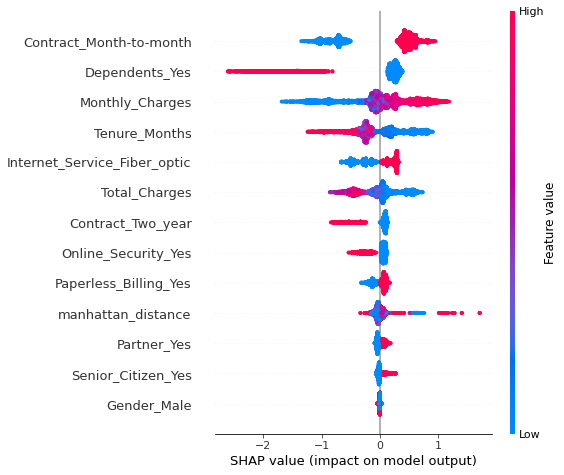

In [29]:
# Plot summary SHAP values for all instances
shap.summary_plot(shap_values, X_train)